# <font color='blue'>SSD (单发多框物体检测器)

我们先动手实现一个皮卡丘检测器，再详细做论文笔记

** 主要原理： **
* 在R-CNN系列模型里，区域提议和分类是分两块来进行的，SSD则将其统一成一个步骤来使得模型更加简单并且速度更加快，这也是其被称为单发的原因，它跟Faster R-CNN主要有两点不一样：
    + 1.对于锚框，我们不再首先判断它是不是含有感兴趣物体，再将正类锚框放入真正物体分类。SSD里面我们直接使用一个num_class+1类分类器来判断它是属于哪类物体，还是只是背景。我们也不会再有额外的回归器对边框进一步进行预测，而是直接使用单个回归其来预测真实边框。
    + 2.SSD不只是对卷积神经网络输出的特征做预测，**它会进一步将特征通过卷积核池化层变小来预测**，这样达到多尺度的效果。

![](http://zh.gluon.ai/_images/ssd.svg)



In [1]:
import utils
import mxnet as mx
import numpy as np

from mxnet import nd
from mxnet import gluon
from mxnet import autograd
from mxnet import metric
from mxnet import image

%matplotlib inline 
import matplotlib as mlt
mlt.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

/home/liang/.virtualenvs/liang-jupyter-2/lib/python3.5/site-packages/mxnet/optimizer.py:136: UserWarning: WARNING: New optimizer mxnet.optimizer.NAG is overriding existing optimizer mxnet.optimizer.NAG
  Optimizer.opt_registry[name].__name__))


##  <font color='blue'>使用gluon下载数据集

In [2]:
import os

root_url = 'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/pikachu/'
data_dir = '../data/pikachu/'

# 一般下载的数据集要包括文件名和拿到该文件hash值 
data_set = {
    'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
    'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
    'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'
}

# download
if not os.path.exists(os.path.join(data_dir, 'val.rec')):
    for k, v in data_set.items():
        gluon.utils.download(url=root_url+k, path=data_dir+k, sha1_hash=v)

## <font color='blue'>读取数据集

In [3]:
batch_size = 4
data_shape = 256
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_classes = len(class_names)
    # 加载训练集以及所做的图像增强
    train_iter = image.ImageDetIter(batch_size=batch_size,
                                    data_shape=(3, data_shape, data_shape),
                                    path_imgrec=data_dir+'train.rec',
                                    path_imgidx=data_dir+'train.idx',
                                    shuffle=True,
                                    rand_crop=True,
                                    mean=True,
                                    min_object_covered=0.95,
                                    max_attempts=200)
    # 加载验证集以及所做的图像增强
    valid_iter = image.ImageDetIter(batch_size=batch_size,
                                    data_shape=(3, data_shape, data_shape),
                                    path_imgrec=data_dir+'val.rec',
                                    shuffle=False,
                                    mean=True)
    return train_iter, valid_iter, class_names, num_classes

train_data, valid_data, class_names, num_classes = get_iterators(data_shape, batch_size)

**我们需要注意标号的形状是$batch\_size \times num\_object\_per\_image \times 5$**

每个图片只有一个标号， 每个标号由长为5的数组表示，第一个表示物体的标号，**<font color="red">-1表示非法物体，仅做填充使用</font>**，后面四个表示边框。

标号含义如下：$[label, top\_left\_x, top\_left\_y, down\_right\_x, down\_right\_y]$

所以有：$width = box[2] - box[0], height = box[3] - box[1]$

In [4]:
for batch in train_data:
    print(batch)
    break
    
# 图片大小shape
print("Image shape:", batch.data[0].shape)
# label的样子
print("Label shape:", batch.label[0].shape)
# 输出单个label
print("Label example:\n", batch.label[0][0])

# 另一种读取批量的方法
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(4, 3, 256, 256)] label shapes: [(4, 1, 5)]
Image shape: (4, 3, 256, 256)
Label shape: (4, 1, 5)
Label example:
 
[[0.         0.68197703 0.36120847 0.82742035 0.5755981 ]]
<NDArray 1x5 @cpu(0)>
DataBatch: data shapes: [(4, 3, 256, 256)] label shapes: [(4, 1, 5)]


## <font color='blue'>显示数据集(只显示图片)

In [5]:
def show_pikachu_images(imgs, nrows, ncols, figsize=None):
    if figsize is None:
        figsize = (nrows, ncols)
    _, figs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            img = imgs[i * ncols + j]
            img = img.transpose((1,2,0)) + rgb_mean
            figs[i][j].imshow((img.clip(0,255) / 255).asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)

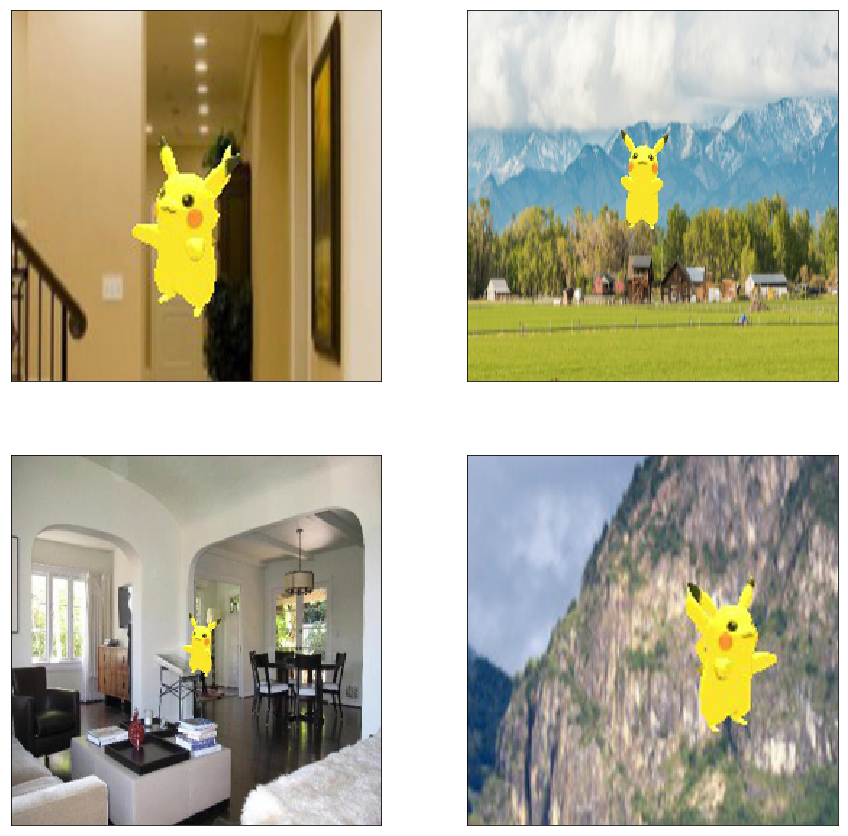

In [6]:
show_pikachu_images(batch.data[0], 2, 2, figsize=(15, 15))

## <font color='blue'>显示数据集(显示图片和标号)

In [7]:
## 定义将标号转变为矩形框的函数
def box_to_rec(bounding_box, color, linewidth=3):
    box = bounding_box.asnumpy()
    rec = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], 
                        fill=False, edgecolor=color, linewidth=linewidth)
    return rec

In [8]:
def show_pikachu_bb_images(batch, nrows, ncols, figsize=None):
    if figsize is None:
        figsize = (nrows, ncols)
    imgs, labels = batch.data[0], batch.label[0]
    _, figs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            img = imgs[i * ncols + j]
            img = img.transpose((1,2,0)) + rgb_mean
            img = img.clip(0, 255) / 255
            figs[i][j].imshow(img.asnumpy())
            # 当每幅图片中有不止一个bounding_box时
            # 此处容易出错，可以多print来确定
            label = labels[i * ncols + j]
            for lab in label:
                figs[i][j].add_patch(box_to_rec(lab[1:5] * data_shape, 'red', 2))
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)

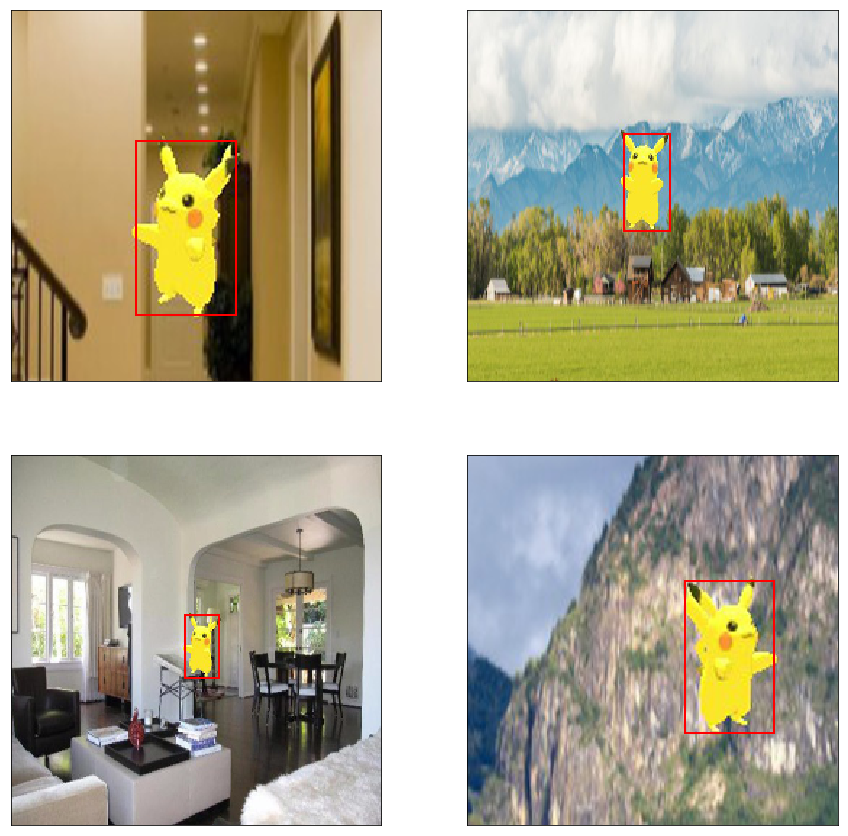

In [9]:
show_pikachu_bb_images(batch, nrows=2, ncols=2, figsize=(15, 15))

## <font color='blue'>SSD模型

### 锚框 (Anchor Box)

每一个锚框通过左上角和右下角的坐标来确定$(x\_min, y\_min, x\_max, y\_max)$

* 对于给定的$s\in(0,1]$，生成的锚框大小为$ws \times hs$
* 对于给定的$r > 0$，生成的锚框大小为$w \sqrt{r}  \times \frac{h}{\sqrt{r}} $

那么对于给定的$s, r$，生成的锚框大小为$w s \sqrt{r}  \times \frac{hs}{\sqrt{r}} $

其中第$i$个锚框使用

+ $sizes[i]$和$ratios[0]$, 如果 $i≤n$
+ $sizes[0]$和$ratios[i-n]$ 如果 $i>n$

In [10]:
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40 
X = nd.random.normal(shape=(1,3,n,n))

y = MultiBoxPrior(X, sizes=[.5, .25, .1], ratios=[1, 2, .5])
# 即使是有n幅图片，产生的y依然是(1,8000,4)，即给定大小和比例，每幅图片产生的锚框是一样的
print("在40*40的图像上可总共产生锚框数：", y.shape) # 40*40*5个 # 默认产生n+m-1个锚框
# 这样reshape的原因是按照生成锚框的顺序
boxes = y.reshape((n,n,-1,4)) # 40*40*5*4 
# 那么在一幅(40*40)的图像上，以(20,20)为中心的n+m-1个锚框就是
print("以(20,20)为中心的n+m-1个锚框为：")
print(boxes[20, 20, :, :])

在40*40的图像上可总共产生锚框数： (1, 8000, 4)
以(20,20)为中心的n+m-1个锚框为：

[[0.2625     0.2625     0.7625     0.7625    ]
 [0.3875     0.3875     0.6375     0.6375    ]
 [0.46249998 0.46249998 0.5625     0.5625    ]
 [0.1589466  0.33572328 0.86605334 0.6892767 ]
 [0.33572328 0.1589466  0.6892767  0.86605334]]
<NDArray 5x4 @cpu(0)>


#### 画出所有以$20 \times 20$为中心的锚框

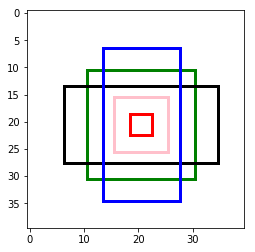

In [11]:
colors = ['green', 'pink', 'red', 'black', 'blue']
plt.imshow((nd.ones((n, n, 3))).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rec(anchors[i, :] * n, colors[i]))

### 预测物体类别

我们使用一个卷积来预测物体类别。

输出的通道数为$num\_anchors\_per\_pixel \times (num\_classes + 1)$，其中对于第i个锚框($i \in [0, num\_anchors\_per\_pixel)$)，有：
* 第$i \times (num\_classes + 1)$个通道表示其为背景的分数
* 第$i \times (num\_classes + 1) + 1 + j$个通道表示其为第$j$个物体的分数($j \in [0, num\_classes)$)

**<font color="red">（先预测背景后类别，这个顺序一定要记住）**

比如，$num\_anchors\_per\_pixel = 5， num\_classes = 10, feature\_map = (20, 20)$时，共有$5 \times (10 + 1)$个输出通道，
* 第$1 \times (10 + 1) = 11$个通道（从0算起）中的400个值表示feature_map上所有$20 \times 20$个像素（从左上往右下的顺序）所对应的第1个（从0算起）锚框是背景的概率；
* 第$1 \times (10 + 1) + 1 + 2 = 14$个通道（从0算起）中的400个值表示feature_map上所有$20 \times 20$个像素（从左上往右下的顺序）所对应的第1个（从0算起）锚框是类别2（从0算起）的概率；

In [12]:
def class_predictor(num_anchors_per_pixel, num_classes):
    '''
    num_anchors_per_pixel : 每个像素生成的锚框数
    num_classes : 总共待检测的类别数
    '''
    return gluon.nn.Conv2D(int(num_anchors_per_pixel * (num_classes + 1)), kernel_size=3, padding=1)

In [13]:
cls_pred = class_predictor(5, 10)
cls_pred.initialize()
X = nd.zeros(shape=(2, 3, 20, 20))
y = cls_pred(X)
print(y.shape)

(2, 55, 20, 20)


### 预测边界框

我们使用与预测物体类别一样的手法来预测边界框。因为我们希望如何通过锚框变成一个真正的边界框，即假设$b$是一个默认的锚框，$Y$是物体的真实边框，我们想预测二者的差值$\Delta (Y, b)$，显然这是一个四维向量，具体来说，我们定义$\Delta (Y, b) = [t_x, t_y, t_{width}, t_{height}]$，有：

$$t_x = (Y_x - b_x) / b_{width}$$
$$t_y = (Y_y - b_y) / b_{height}$$
$$t_{width} = (Y_{width} - b_{width}) / b_{width}$$
$$t_{height} = (Y_{height} - b_{height}) / b_{height}$$

除以$b_{width}/b_{height}$是为了更好的收敛(即Normalizing)。

实际上我们可以将边界框的预测理解为$num\_classes=4$的类别预测，那么第$i$个锚框所对应的边框预测的值就在第$i \times 4 $至$i \times 4 + 3$通道中。

In [14]:
def box_predictor(num_anchors_per_pixel):
    '''
    num_anchors_per_pixel : 每个像素生成的锚框数
    '''
    return gluon.nn.Conv2D(int(num_anchors_per_pixel * 4), kernel_size=3, padding=1)

In [15]:
box_pred = box_predictor(10)
box_pred.initialize()
X = nd.zeros(shape=(2, 3, 20, 20))
y = box_pred(X)
print(y.shape)

(2, 40, 20, 20)


### 减半模块

将输入特征的长宽减半，以获得多尺度的预测。加两层``Conv->BN-ReLU``的原因是为了使得网络变得更深

In [16]:
def down_sample(num_filters):
    down = gluon.nn.HybridSequential()
    with down.name_scope():
        for _ in range(2):
            down.add(
                gluon.nn.Conv2D(num_filters, kernel_size=3, padding=1),
                gluon.nn.BatchNorm(axis=1, epsilon=2e-5),
                gluon.nn.Activation('relu')
            )
        down.add(gluon.nn.MaxPool2D(pool_size=2, strides=2))
    return down

In [17]:
blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))    
print('Before', x.shape, 'after', blk(x).shape)

Before (2, 3, 20, 20) after (2, 10, 10, 10)


### 合并来自不同层的输出

SSD的一个重要特性就是多尺度的预测，这样会导致的一个问题是每个尺度的输出尺寸大小有所不同，看个例子。

In [18]:
X = nd.random.normal(shape=(2,8,20,20))

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(X)
print("cls_pred1: ", y1.shape)

down = down_sample(16)
down.initialize()
X = down(X)
print('down_sample x: ', X.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(X)
print("cls_pred2:", y2.shape)

cls_pred1:  (2, 55, 20, 20)
down_sample x:  (2, 16, 10, 10)
cls_pred2: (2, 33, 10, 10)


可以看到经减半模块后$y1$和$y3$有着不同的$shape$，我们将不同层的输出合并成一个输出便于处理，我们先将通道层移到最后的维度，再展开成2D矩阵

我们将通道层先移到最后的维度再展开的原因是**将通道层移到最后可以将以某一像素点为中心生成的所有锚框(参见上面的(2,55,20,20))相对于所有类别的预测分数都保存在一行中，这样transpose之后不同行保存的就是以不同像素点为中心生成的所有锚框相对于所有类别的预测分数，那么在展开成2D矩阵时，就会把下一行的信息追加在当前行之后，这样一来，以每个像素点为单位所生成的所有锚框相对于类别的预测信息（对边框的预测信息也是一样的道理）就全部被保存在了一起，有点类似于按段划分，这样是比较合理的。最重要的一点是， 这样便于还原。**

In [19]:
a = nd.arange(12).reshape((1,3,2,2))
b = a.transpose((0,2,3,1))
c = b.flatten()
print("原始数据：", a)
print("将通道层transpose到最后：", b)
print("展开之后：", c)

原始数据： 
[[[[ 0.  1.]
   [ 2.  3.]]

  [[ 4.  5.]
   [ 6.  7.]]

  [[ 8.  9.]
   [10. 11.]]]]
<NDArray 1x3x2x2 @cpu(0)>
将通道层transpose到最后： 
[[[[ 0.  4.  8.]
   [ 1.  5.  9.]]

  [[ 2.  6. 10.]
   [ 3.  7. 11.]]]]
<NDArray 1x2x2x3 @cpu(0)>
展开之后： 
[[ 0.  4.  8.  1.  5.  9.  2.  6. 10.  3.  7. 11.]]
<NDArray 1x12 @cpu(0)>


In [20]:
d = c.reshape(shape=(0,-1,3))
d


[[[ 0.  4.  8.]
  [ 1.  5.  9.]
  [ 2.  6. 10.]
  [ 3.  7. 11.]]]
<NDArray 1x4x3 @cpu(0)>

In [21]:
def flatten_pred(pred):
    return pred.transpose((0,2,3,1)).flatten()

def concat_preds(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_pred(y1)
print('flat_y1: ', flat_y1.shape)
flat_y2 = flatten_pred(y2)
print('flat_y2: ', flat_y2.shape)
print('concat cls preds: ', concat_preds([flat_y1, flat_y2]).shape)

flat_y1:  (2, 22000)
flat_y2:  (2, 3300)
concat cls preds:  (2, 25300)


### 主体网络

主体网络通常用来从原始图片抽取图像特征，我们通常使用ResNet,DenseNet等都可以，但是这里为了简单，我们仅仅将几个down_sample模块stack起来从而构成主体网络 。

In [22]:
def body_network(): 
    body = gluon.nn.HybridSequential()
    with body.name_scope():
        for nfilters in [16, 32, 64]:
            body.add(down_sample(nfilters))
    return body

In [23]:
body = body_network()
body.initialize()
X = nd.zeros((2, 3, 256, 256))
y = body(X)
y.shape
print("Body Network: ", [y.shape for y in body(X)])

Body Network:  [(64, 32, 32), (64, 32, 32)]


### 创建SSD模型

该模型包含四块。主体网络，三个减半模块，以及五个物体类别和边框预测模块。其中预测分别应用在**在主体网络输出，减半模块输出，和最后的全局池化层上**。

In [24]:
def ssd_model(num_anchors_per_pixel, num_classes):
    downsamples = gluon.nn.Sequential()
    class_predictors = gluon.nn.Sequential()
    box_predictors = gluon.nn.Sequential()
    
    for _ in range(3):
        downsamples.add(down_sample(128))
    
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors_per_pixel, num_classes))
        box_predictors.add(box_predictor(num_anchors_per_pixel))
    ssd_model = gluon.nn.Sequential()
    with ssd_model.name_scope():
        ssd_model.add(body_network(), downsamples, class_predictors, box_predictors)
    return ssd_model

In [25]:
ssd_model(5, 1)

Sequential(
  (0): HybridSequential(
    (0): HybridSequential(
      (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(use_global_stats=False, eps=2e-05, fix_gamma=False, axis=1, momentum=0.9, in_channels=None)
      (2): Activation(relu)
      (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(use_global_stats=False, eps=2e-05, fix_gamma=False, axis=1, momentum=0.9, in_channels=None)
      (5): Activation(relu)
      (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    )
    (1): HybridSequential(
      (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm(use_global_stats=False, eps=2e-05, fix_gamma=False, axis=1, momentum=0.9, in_channels=None)
      (2): Activation(relu)
      (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm(use_global_stats=False, eps=2e-05, fix_gamma=False, a

### 计算预测

给定模型和预测使用的锚框的大小和形状，我们可以定义前向函数

In [26]:
def ssd_forward(X, ssd_model, sizes, ratios, verbose=False):
    body, downsamples, class_predictors, box_predictors = ssd_model
    # 主体网络输出
    X = body(X)
    # 定义合并数组，将来自不同尺度的结果进行合并
    anchors, class_preds, box_preds = [], [], []
    # 5个阶段的多尺度预测
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(X, sizes=sizes[i], ratios=ratios[i]))
        # 保存的都是flatten的结果，便于后面将不同层的特征做合并
        class_preds.append(flatten_pred(class_predictors[i](X)))
        box_preds.append(flatten_pred(box_predictors[i](X)))
        
        # debug
        if verbose:
            # anchors[-1].shape[1]取最新append进去的，即当前生成锚框的个数
            print("Predict scale", i, "ratio", i, ",Output shape : ", X.shape, ", With", anchors[-1].shape[1], "anchors.")
        
        # downsample
        if i < 3:
            X = downsamples[i](X)
        elif i == 3:
            X = nd.Pooling(X, global_pool=True, pool_type='max', kernel=(X.shape[2], X.shape[3]))
    
    # 将来自不同尺度的结果进行合并
    return (concat_preds(anchors), concat_preds(class_preds), concat_preds(box_preds))

### 构建完整的SSD模型

In [27]:
class SSD(gluon.nn.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super().__init__(*kwargs)
        self.anchor_sizes = [[.2, .272], [.37, .447], [.54, .619], [.71, .79], [.88, .961]]
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes 
        self.verbose = verbose
        
        num_anchors_per_pixel = len(self.anchor_sizes[0]) + len(self.anchor_ratios[0]) - 1 # m+n-1
        with self.name_scope():
            self.model = ssd_model(num_anchors_per_pixel, num_classes)
            
    def forward(self, X):
        anchors, class_preds, box_preds = ssd_forward(X, self.model, self.anchor_sizes, 
                                                      self.anchor_ratios, self.verbose)
        # 将对类别的预测信息还原回（batch_size，-1， num_class+1）的形式
        class_preds = class_preds.reshape(shape=(0, -1, int(self.num_classes+1)))
        return anchors, class_preds, box_preds

In [28]:
net = SSD(num_classes=2, verbose=True)
net.initialize()

### 观察数据维度的变化

Input shape:  (1, 3, 256, 256)<br>
Predict scale 0 Output shape :  (1, 64, 32, 32) , With 4096 anchors. $32 \times 32 \times (2+3-1)$<br>
Predict scale 1 Output shape :  (1, 128, 16, 16) , With 1024 anchors. $16 \times 16 \times (2+3-1)$<br>
Predict scale 2 Output shape :  (1, 128, 8, 8) , With 256 anchors. $8 \times 8 \times (2+3-1)$<br>
Predict scale 3 Output shape :  (1, 128, 4, 4) , With 64 anchors. $4 \times 4 \times (2+3-1)$<br>
Predict scale 4 Output shape :  (1, 128, 1, 1) , With 4 anchors. $1 \times 1 \times (2+3-1)$<br>
Out anchors:  (1, 5444, 4).  $4096 + 1024 + 256 + 64 + 4$<br> 
Out class preds:  (1, 16332) $5444 \times (2 + 1) \to (1, 5444, 3)$<br>
Out box preds:  (1, 21776) $5444 \times 4$

In [29]:
X = batch.data[0][:1]
print("Input shape: ", X.shape)
anchors, class_preds, box_preds = net(X)
print("Out anchors: ", anchors.shape)
print("Out class preds: ", class_preds.shape)
print("Out box preds: ", box_preds.shape)

Input shape:  (1, 3, 256, 256)
Predict scale 0 ratio 0 ,Output shape :  (1, 64, 32, 32) , With 4096 anchors.
Predict scale 1 ratio 1 ,Output shape :  (1, 128, 16, 16) , With 1024 anchors.
Predict scale 2 ratio 2 ,Output shape :  (1, 128, 8, 8) , With 256 anchors.
Predict scale 3 ratio 3 ,Output shape :  (1, 128, 4, 4) , With 64 anchors.
Predict scale 4 ratio 4 ,Output shape :  (1, 128, 1, 1) , With 4 anchors.
Out anchors:  (1, 5444, 4)
Out class preds:  (1, 5444, 3)
Out box preds:  (1, 21776)


## <font color='blue'>训练
    
### IoU（Intersection Over Union）

我们通过交并比来判断两个边框是否相似，交并比的定义为：

![](http://zh.gluon.ai/_images/iou.svg)

从定义中可以看出，交并比大的值表示两个边框很相似，越小代表两个边框越不相似。

### 损失函数

分类问题中我们直接使用交叉熵损失函数来进行实验，但是检测问题中的一个问题是，一张图片中可能只有几个标注的边框（我们称之为感兴趣物体，ROI，Region Of Interest），但是我们针对每个像素都生成了n+m-1个锚框，因此我们生成的总锚框数远远大于图片中真实标注的数量，那么这会导致产生大量的负类样本，即和感兴趣物体的IoU值小于某个阈值的锚框，或者我们称之为标号为0的边框，对于这些边框，我们需要考虑以下问题：

* 边框预测的损失函数中不应该包含标号为0的边框，因为他们没有对应的真实边框。
* 因为负类样本的数量(和RoI的IOU小于某个阈值)可能远大于其他(和RoI的IOU大于某个阈值)，因此我们只需要保留其中的一些父类样本即可，而且是保留那些目前最不确定它是负类的样本，即对标号为0的边框的预测值进行排序，选择数值较小的那些负类样本（数值越小表示越不确定它是负类）。

我们可以使用``MultiBoxTarget``来完成上面这两个操作。

In [30]:
from mxnet.contrib.ndarray import MultiBoxTarget

def training_targets(anchors, class_preds, labels):
    # 这里为什么要transpose可能因为是函数MultiBoxTarget需要
    class_preds = class_preds.transpose((0, 2, 1))   
    # overlap_threshold = 0.5 可以通过实验证明交并比的阈值是0.5，我们可以在这里随机设置交并比的阈值
    return MultiBoxTarget(anchor=anchors, label=labels, cls_pred=class_preds)

In [31]:
out = training_targets(anchors=anchors, class_preds=class_preds, labels=batch.label[0][:1])

它返回三个NDArray，分别是：
* 1.预测的边框跟真实边框的偏移，大小是$batch\_size \times (num\_anchors * 4)$
    + 偏移量是一个四元组，所以数组中出现的值一定是4个连在一起的
    + 记为 **box_target**
* 2.用来遮掩不需要的负类锚框的掩码，大小跟上面一致
    + 可以看出非零的部分一定是与上面的偏移是对应的，且只要是上面非的地方，在该掩码中一定是1，其余均为0
    + 记为 **box_mask**
* 3.锚框的真实标号（在本次计算中到底是正类还是负类，即是否选用该锚框，如果是正类，是哪一类），大小是$batch\_size \times num\_anchors$
    + 0表示是背景，1表示是类别1，2表示是类别2，依此类推... 
    + 记为 **class_target**

In [32]:
out

[
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[0. 0. 0. ... 0. 0. 0.]]
 <NDArray 1x5444 @cpu(0)>]

我们可以计算这次只选中了多少个锚框进入损失函数

In [33]:
out[1].sum() / 4


[38.]
<NDArray 1 @cpu(0)>

同样，利用第三个值我们同样可以计算出满足阈值要求(大于IOU)的锚框数(即非0数)

In [34]:
out[2].sum()


[38.]
<NDArray 1 @cpu(0)>

然后我们就可以定义我们所需要的损失函数了，考虑到正负样本之间比例可能会失衡，因此对于物体类别预测问题，我们使用一个更为鲁棒的损失函数，被称为Focal Loss.

## Focal Loss 

Focal Loss通过施加缩放因子降低易分类样本在训练过程中对于损失函数贡献，其中缩放因子随着对正确类别的置信度的增加而衰减到0，从而使得损失函数更加关注难分类样本，给定正的$\lambda$和$\alpha$，$j$表示真实的类别，$p_j$是对应的预测概率。它的定义是

$$FL(p_j) = - \alpha (1 - p_j)^{\lambda}log(p_j)$$

通过图示可以看到，随着$\lambda$的增加，可以使得对正类预测值比较大时损失变小。

In [35]:
def focal_loss(gamma, x):
    return -(1 - x)**gamma*np.log(x)

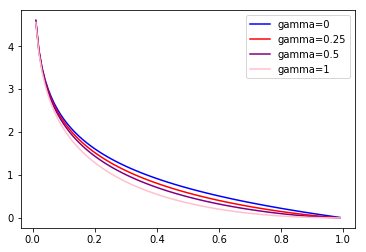

In [36]:
sample = np.arange(0.01, 1, 0.01)
gamma = [0, .25, .5, 1]
colors = ['blue', 'red', 'purple', 'pink']
for i, ga in enumerate(gamma):
    plt.plot(sample, focal_loss(ga, sample), colors[i])
plt.legend(['gamma='+str(ga) for ga in gamma])
plt.show()

我们通过继承``gluon``的``Loss``基类来实现这个函数

In [37]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        '''
        axis : 表示pick时候用到的轴，axis为负数表示反向选取轴信息
        alpha : 
        gamma : 
        batch_axis : batch_size所在的轴
        '''
        super().__init__(None, batch_axis, **kwargs) # weight, batch_axis, 均继承自gluon.loss.Loss
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma 
        self.batch_axis = batch_axis
        
    def hybrid_forward(self, F, pred, label): # 均继承自loss的参数
        '''
        pred : 来自class_predictors类别预测的结果（class_preds）
            shape = (batch_size, num_anchors, num_class+1) 
            num_anchors = num_anchors_per_pixel * (n+m-1)
        label : 锚框所代表图片的真实标号 非0的个数代表本次计算损失有多少个锚框满足IOU的要求
            shape = (batch_size, num_anchors)
        '''
        # 输入：（1, 5144, 2）两类
        pred = F.softmax(pred) # 转换为概率值
        # 输出：(1, 5144, 1) pj是对应类别的预测概率
        # 在本例子中，0代表背景，1代表皮卡丘 label是真实标签，这么一来就很好理解了
        pj = pred.pick(label, axis=self._axis, keepdims=True)
        # compute loss
        # 一开始这边忘记加上负号了 要注意
        loss = - self._alpha * ((1 - pj)**self._gamma) * pj.log()
        return loss.mean(axis=self.batch_axis, exclude=True)

In [38]:
cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

## Smooth L1 Loss

对于边框的预测是一个回归问题，我们通常可以选择平方损失函数（L2损失），但这个损失对于比较大的误差的惩罚很高。我们可以采用稍微缓和一点的绝对损失函数（L1损失），它是随着误差线性增长，而不是平方增长，但是这个函数在0处不可导，因此可能会影响收敛。一个通常的解决办法是在0点附近使用平方函数使得他更加平滑，这杯称为平滑L1损失函数，他通过一个参数$\sigma$来控制平滑的区域：

\begin{split}f(x) =
    \begin{cases}
    (\sigma x)^2/2,& \text{if }x < 1/\sigma^2\\
    |x|-0.5/\sigma^2,& \text{otherwise}
    \end{cases}\end{split}
    
我们通过不同的$\sigma$来掩饰平滑L1损失和L2损失的区别。

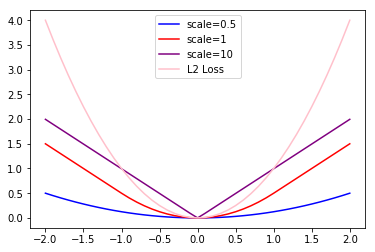

In [39]:
scales = [.5, 1, 10]
x = nd.arange(-2, 2.1, 0.1)

for i, s in enumerate(scales):
    y = nd.smooth_l1(x,scalar=scales[i])
    plt.plot(x.asnumpy(), y.asnumpy(), color=colors[i])
plt.plot(x.asnumpy(), (x**2).asnumpy(), color=colors[3])
plt.legend(['scale='+str(s) for s in scales]+['L2 Loss']) 

我们同样通过继承``gluon``的``Loss``基类来实现这个函数，同时它接受一个额外的参数mask，这是用来屏蔽掉不需要被惩罚的样本

In [40]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super().__init__(None, batch_axis, **kwargs)
        
    def hybrid_forward(self, F, pred, label, mask):
        # 通过掩码将负类边框置为0，
        loss = F.smooth_l1((pred - label) * mask, scalar=1.)
        return loss.mean(axis=self._batch_axis, exclude=True)

In [41]:
box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

## 定义评估测量函数

对于分类好坏我们可以沿用之前的分类精度。评估边框预测好坏的一个常用方法是平均绝对误差，线性回归中使用的是平均平方误差(MAE, Mean Absolute Estimation)，但是跟上面对损失函数的讨论一样，平方误差对于大的误差给予过大的值，从而数值上过于敏感。平均绝对误差就是将二次项替换成绝对值，具体来说就是**预测的边框和真实边框在4个维度上的差值的绝对值**。

In [42]:
cls_metric = metric.Accuracy()
box_metric = metric.MAE()

## 初始化模型和训练器

In [43]:
# CUDA加速需要每张图片至少有3个label，因此我们将每个label pad至(3,5)，pad的值默认均为-1。
train_data.reshape(label_shape=(3, 5)) 
valid_data = train_data.sync_label_shape(valid_data, verbose=False)

In [44]:
ctx = mx.cpu()

net = SSD(num_classes)
net.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(rnd_type='gaussian', factor_type='in', magnitude=2.))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

## 训练模型

In [45]:
from time import time 

niter = 0
moving_loss = .0
smooth_const = 0.9

epochs = 50
for epoch in range(epochs):
    train_data.reset()
    valid_data.reset()
    cls_metric.reset()
    box_metric.reset()
    start = time()
    for i, batch in enumerate(train_data):
        data = batch.data[0].as_in_context(ctx)
        labels = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(data)
            box_target, box_mask, class_target = training_targets(anchors, class_preds, labels)
            '''
            class_preds : class_predictors模块的类别预测信息
            class_target : 每个锚框的真实类别信息
            '''
            loss1 = cls_loss(class_preds, class_target)
            '''
            box_preds : 边框四元组的预测信息，数量为num_anchors * 4
            box_target : 锚框与物体真实边框的偏移量，是边框四元组的真实信息
            box_mask : 大小同box_mask，用来屏蔽不需要的锚框的掩码
            '''
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
            
            niter += 1
            curr_loss = nd.mean(loss).asscalar()
            moving_loss = smooth_const * moving_loss + (1 - smooth_const) * curr_loss
            estimated_loss = moving_loss / (1 - smooth_const**niter)
            
        loss.backward()
        trainer.step(batch_size)
        
        # 更新评估信息
        # 分类准确率的指标
        cls_metric.update([class_target], [class_preds.transpose((0,2,1))])
        # 
        box_metric.update([box_target], [box_preds * box_mask])
        
    print("[Epoch %d], Train loss %.5f, Train %s %.5f, %s %.5f, time %.4f s" 
          % (epoch, estimated_loss, *cls_metric.get(), *box_metric.get(), time()-start))

KeyboardInterrupt: 